In [1]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [284]:
def generate_random_price_series(periods: int = 252, volatility:float = 0.01, freq: str = 'B'):

        date_range = pd.date_range(start='2100-01-01', periods=periods, freq=freq)
        # TODO: Implement random series with distributions other than normal
        returns = np.random.normal(loc=0.005, scale=volatility, size=periods)
        prices = 100 * (1 + returns).cumprod()

        return pd.Series(prices, index=date_range, name='price')

#### 1. Sampling for reduction
What conditions should preceed the algorithms training data

In [3]:
# 1. CUMSUM filter - when a cumulative price movement has taken place
# 2. Tight volatility range - consolidation period leads to bigger move
def inverse_cumsum_filter(series: pd.Series, h: float, n: int) -> pd.Series:
    """
    Apply a cumulative sum filter to a time series based on a rolling period.
    
    Parameters:
    - series: pd.Series, time series of prices with time stamp index
    - h: float, threshold value for filtering
    - n: int, lookback period for the rolling window
    
    Returns:
    - pd.Series, boolean series where True indicates dates flagged by the filter
    """
    returns = series.pct_change()       
    # Ensure the series is sorted by index (time)
    returns = returns.add(1)
    
    # Calculate the rolling cumulative sum over the lookback period n
    rolling_cumsum = returns.rolling(window=n).apply(np.prod) -1
    
    # Flag dates where the cumulative return is less than the absolute value of h
    flagged = (rolling_cumsum.abs() < h)
    
    return flagged

def plot_with_flags(series: pd.Series, flagged: pd.Series):
    """
    Plots a time series and highlights flagged dates as red dots.
    
    Parameters:
    - series: pd.Series, the original time series of returns with timestamp index
    - flagged: pd.Series, boolean series indicating flagged dates
    """
    # Ensure the series is sorted by time index
    series = series.sort_index()

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Time Series', color='blue')

    # Highlight flagged dates as red dots
    plt.scatter(series.index[flagged], series.values[flagged], color='red', label='Flagged Dates')

    # Add labels and legend
    plt.title(f"Time Series with Flagged Dates; Percent labels = {np.average(flagged)*100}%")
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()


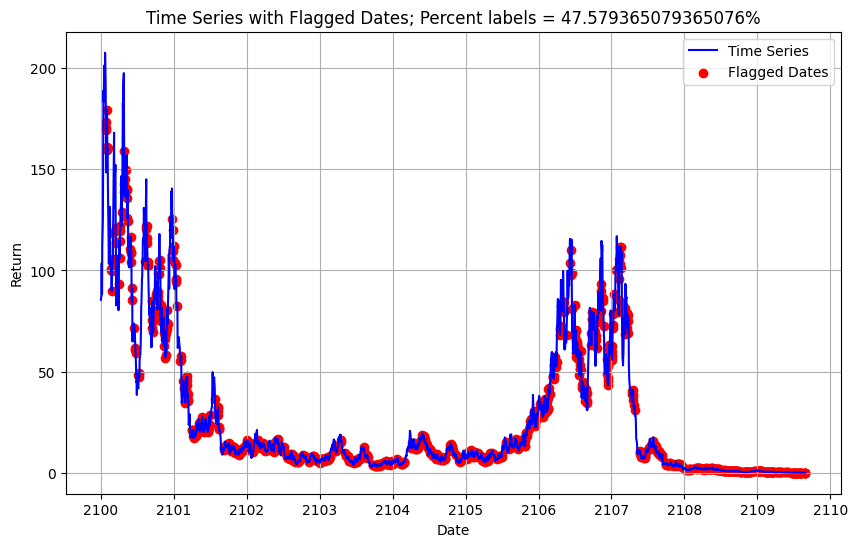

In [301]:
# Apply the cumsum_filter with a threshold h and a lookback period n
close = generate_random_price_series(periods=2520, volatility=0.1)

h = 0.19
n = 10
flagged_dates = inverse_cumsum_filter(close, h, n)
# percent_labels = np.average(flagged_dates)*100

plot_with_flags(series = close, flagged = flagged_dates)

In [5]:
def generate_percent_label_matrix(samples: int = 100, n_min: int = 3, n_max: int = 31, h_min = 0.01, h_max = 0.11):
    """
    Generate a matrix of % label values for different combinations of h and n.
    
    h ranges from 0.01 to 0.2 with a step of 0.01.
    n ranges from 3 to 30 with a step of 1.
    The % label is based on an average of 100 random series.
    
    Returns:
    - pd.DataFrame, with rows as n values and columns as h values, containing % label values.
    """
    h_step = (h_max-h_min)/10
    # Range of h values from 0.01 to 0.2 with step 0.01
    h_values = np.arange(h_min, h_max, h_step)
    # Range of n values from 3 to 30 with step 1
    n_values = np.arange(n_min, n_max, 1)
    
    # Initialize an empty matrix to store % label values
    percent_label_matrix = np.zeros((len(n_values), len(h_values)))

    # Perform calculations
    for i, n in enumerate(n_values):
        for j, h in enumerate(h_values):
            # Average percent labels over 100 random series
            percent_labels = []
            for _ in range(samples):  # Generate 100 random series
                cumulative = generate_random_price_series(volatility=0.1)  # Generate random return series
                flagged_dates = inverse_cumsum_filter(cumulative, h, n)  # Apply filter
                percent_labels.append(np.average(flagged_dates) * 100)  # Calculate % flagged
            
            # Store the average % label in the matrix
            percent_label_matrix[i, j] = np.mean(percent_labels)
    
    # Convert the matrix into a DataFrame for better readability, with n as index and h as columns
    percent_label_df = pd.DataFrame(percent_label_matrix, index=n_values, columns=h_values)
    
    return percent_label_df

def plot_percent_label_matrix(matrix: pd.DataFrame, lower_threshold: float = 18, upper_threshold: float = 62):
    """
    Visualize the percent label matrix using a heatmap.
    
    Parameters:
    - matrix: pd.DataFrame, matrix of % label values where rows are n values and columns are h values
    """
    # Create a mask for values less than the threshold
    mask = (matrix < lower_threshold) | (matrix > upper_threshold)
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, mask=mask, annot=True, cmap="YlGnBu", cbar_kws={'label': '% Label'}, 
                vmin=lower_threshold, linewidths=0.5, linecolor='gray')
    
    # Set the labels and title
    plt.title('Heatmap of % Label Values for Different n and h')
    plt.xlabel('h (Threshold)')
    plt.ylabel('n (Lookback Period)')
    
    # Show the plot
    plt.show()

In [282]:
# # Assuming percent_label_matrix is the output from generate_percent_label_matrix()
# percent_label_matrix = generate_percent_label_matrix(samples=100, h_min=0.05, h_max=0.25)
# percent_label_matrix.to_csv('percent_label_matrix_0_1vol.csv', index=True)

In [8]:
percent_label_matrix = pd.read_csv('data/percent_label_matrix_0_1vol.csv').set_index("Unnamed: 0")

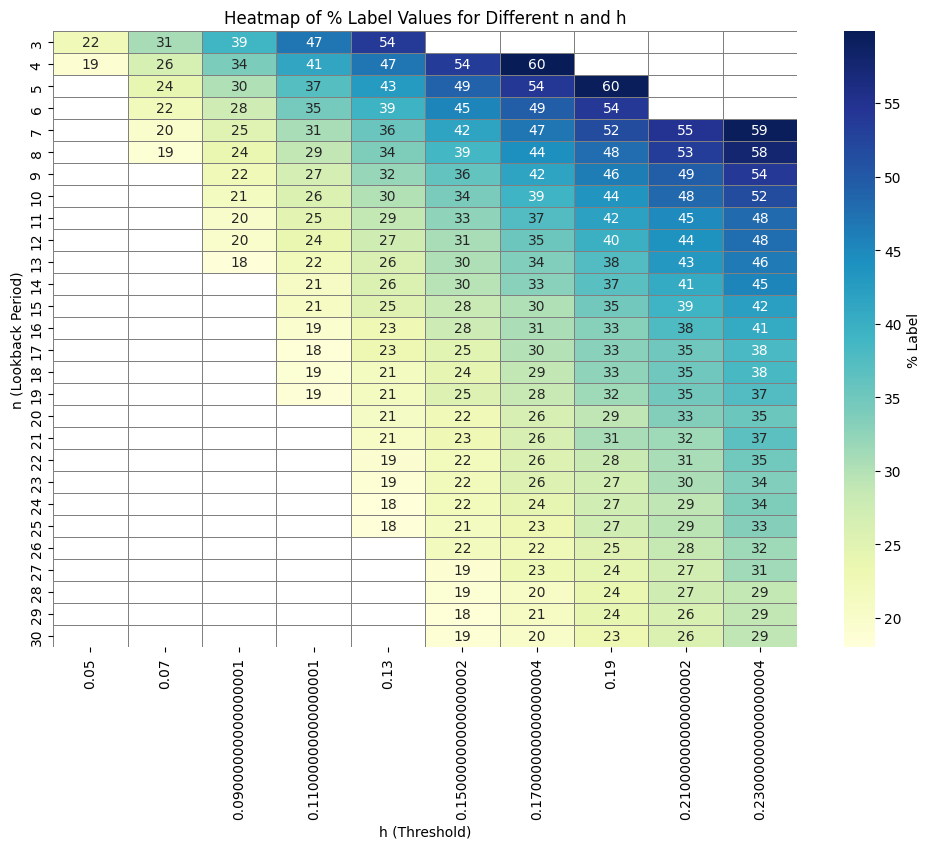

In [9]:
# Visualize the matrix
plot_percent_label_matrix(percent_label_matrix, upper_threshold=60)

#### 2. Triple barrier method

Vertical barrier: 3x-4x of inverse cumsum lookback period
Upper/lower barrier: 3x to 4x of inverse cumsum threshold

In [34]:
# Getting dates for the vertical barrier
def get_vertical_barrier(t_events, close, num_days=1):
    """Get a datetime index of dates for the vertical barrier

    Args:
        tEvents (datetime index): dates when the algorithm should look for trades
        close (pd.Series): series of prices
        numDays (int, optional): vertical barrier limit. Defaults to 1.

    Returns:
        pd.Series: series of datetime values
    """
    t1=close.index.searchsorted(t_events+pd.Timedelta(days=num_days))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=t_events[:t1.shape[0]]))
    return t1

In [35]:
def find_min_column(row):
    # Find the minimum value excluding 'vb' if it ties with another column
    # print(row['vb'])
    # print(row['sl'])
    # print(row['pt'])
    # print("+++")
    if pd.isnull(row['pt']) & pd.isnull(row['sl']):
        min_value = row[['pt', 'sl']].min()
    else:
        min_value = pd.Timestamp(0)
    return row[['pt', 'sl']].idxmin() if min_value <= row['vb'] else row[['pt', 'sl', 'vb']].idxmin()

In [36]:
def triple_barrier_method(close, t_events: pd.Series, pt_sl: int, n_days:int):
    trgt = pd.Series(0.01, index=t_events)

    v_bars = get_vertical_barrier(t_events, close, n_days)
    pt_sl = [pt_sl, -pt_sl]

    events = pd.concat({'vb':v_bars, 'trgt': trgt}, axis=1).dropna(subset=['trgt'])

    exits = events[['vb']].copy(deep=True)

    pt = pt_sl[0]*events['trgt']
    sl = pt_sl[1]*events['trgt']

    for event, vb in events['vb'].fillna(close.index[-1]).items():

        price_path = close[event:vb]
        return_path = (price_path/close[event]-1)
        exits.loc[event,'sl'] = return_path[return_path<sl[event]].index.min() # earliest stop loss
        exits.loc[event,'pt'] = return_path[return_path>pt[event]].index.min() # earliest profit taking

    
    exits['vb'] = exits['vb'].fillna(close.index[-1])
    exits['barrier_hit'] = exits.apply(find_min_column, axis=1)
    exits['hit_date'] = exits[['vb', 'sl', 'pt']].min(axis=1)
    exits['returns'] = close[exits['hit_date']].values/close[t_events].values -1
    exits['bin'] = np.sign(exits['returns'])
    exits.loc[exits['barrier_hit']=='vb', 'bin'] = 0

    return exits[['bin', 'returns', 'hit_date']]

In [113]:
# exits_ = exits.dropna(subset=['vb'])
# px = exits_.index.union(exits_['vb'].values).drop_duplicates()
# px = close.reindex(px, method='bfill')

# out = pd.DataFrame(index=exits_.index)
# out['ret'] = px.loc[exits_['vb'].values].values / px.loc[exits_.index] - 1
# out['bin'] = np.sign(px.loc[exits_['vb'].values].values / px.loc[exits_.index] - 1)

# vtouch_first_idx = exits[exits['vb'].isin(v_bars.values)].index
# out.loc[vtouch_first_idx, 'bin'] = 0.

In [72]:
def calculate_zero_bin_percentage(n_samples):
    # Initialize a matrix to store the results
    n_values = range(5, 45, 5)
    h_values = range(5, 45, 5)
    matrix = np.zeros((8, 8))

    # Loop through values of n (1 to 30) and h (1 to 10)
    for n in n_values:
        for h in h_values:
            zero_counts = []
            for _ in range(n_samples):
                # Call triple_barrier_method and get the DataFrame
                close = generate_random_price_series(periods=252, volatility=0.1)
                t_events = inverse_cumsum_filter(close, 0.19, 10)
                t_events = t_events[t_events].index
                df = triple_barrier_method(close, t_events, h, n)
                # Calculate the percentage of bin values that are zero
                zero_percentage = (df['bin'] == 0).mean() * 100
                zero_counts.append(zero_percentage)
            # Store the average percentage in the matrix
            matrix[int(n/5)-1, int(h/5)-1] = np.mean(zero_counts)

    # Convert the matrix into a DataFrame for better readability, with n as index and h as columns
    percent_label_df = pd.DataFrame(matrix, index=n_values, columns=h_values)
    
    return percent_label_df

In [73]:
bin_dist = calculate_zero_bin_percentage(100)
bin_dist.to_csv('data/bin_dist_0_1vol.csv')

In [17]:
bin_dist = pd.read_csv("bin_dist.csv").set_index("Unnamed: 0")

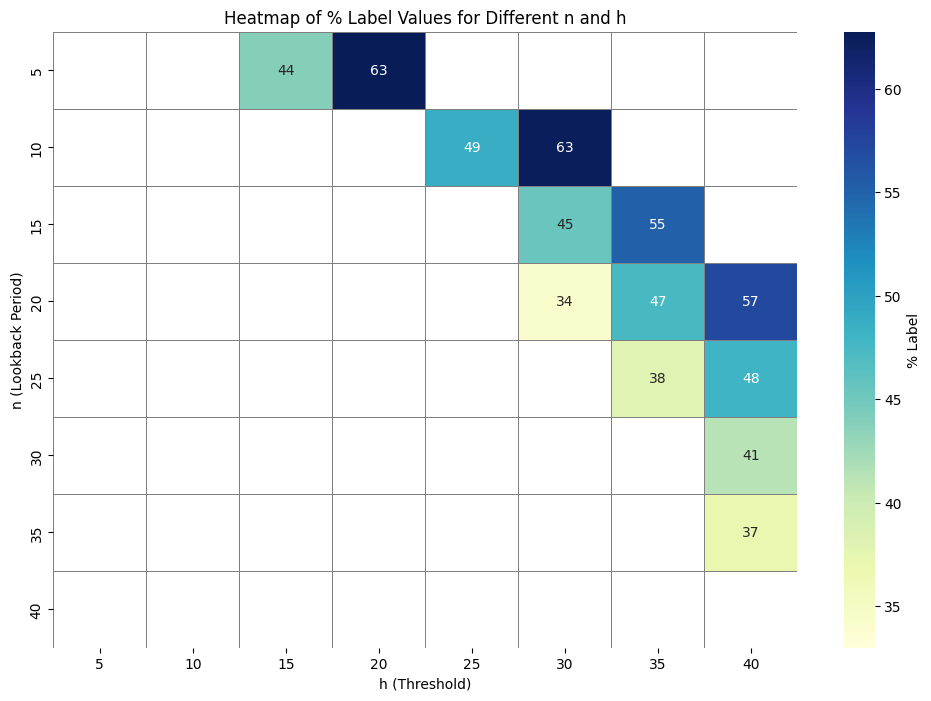

In [74]:
# Visualize the % of observations that were labelled 0 (no position)
# n = lookforwad period/ length of trades/ 1 = 1 period after event
# h = upper and lower barrier width/ magnitude of trade/ 1 = 1% up or down from event
plot_percent_label_matrix(bin_dist, lower_threshold=33, upper_threshold=66)

#### 3. Sample Weights

In [302]:
def num_co_events(close_idx, t_exits):
    '''
    Compute the number of concurrent events per bar across the entire `closeIdx` range.
    
    Any event that starts before the maximum of `t1` impacts the count.
    '''
    # 1) Handle unclosed events (events with NaN end date)
    t_exits.fillna(close_idx[-1])
      # unclosed events affect the count
    
    # 2) Find the relevant range of events
    t_exits = t_exits[t_exits >= close_idx[0]]  # events that end after the first closeIdx time
    t_exits = t_exits.loc[:t_exits.max()]  # events that start at or before the latest event in t1
    
    # 3) Initialize a count series covering the entire closeIdx range
    iloc = close_idx.searchsorted(np.array([t_exits.index[0], t_exits.max()]))
    count = pd.Series(0, index=close_idx[iloc[0]:iloc[1] + 1])
    
    # 4) Count events that span each bar in closeIdx
    for t_in, t_out in t_exits.items():
        count.loc[t_in:t_out] += 1
    
    return count

In [303]:
t_events = inverse_cumsum_filter(close, h=0.19, n=10)
t_events = t_events[t_events].index
t_exits = triple_barrier_method(close, t_events, 30, 20)['hit_date']

close_idx = close.index

co_events = num_co_events(close_idx, t_exits)

In [304]:
def average_uniqueness(t_exits, co_events):
    wght = pd.Series(index=t_exits.index)
    for t_in, t_out in t_exits.items():
        wght.loc[t_in] = (1./co_events.loc[t_in:t_out]).mean()

    return wght

In [305]:
uniqueness = average_uniqueness(t_exits, co_events)

In [306]:
# Absolute return adjusted weights
# Labels associated with high absolute return should begiven more importance than labels with negligible absolute returns
# Determination of sample weight by absolute return attribution [4.10]
def ret_adj_weigth(t_exits, co_events, close):
    # Derive sample weight by return attribution
    ret = np.log(close).diff() # log-returns, so that they are additive
    wght = pd.Series(index=t_exits.index)
    for t_in, t_out in t_exits.loc[wght.index].items():
        wght.loc[t_in]=(ret.loc[t_in:t_out]/co_events.loc[t_in:t_out]).sum()
    return wght.abs()

<Axes: >

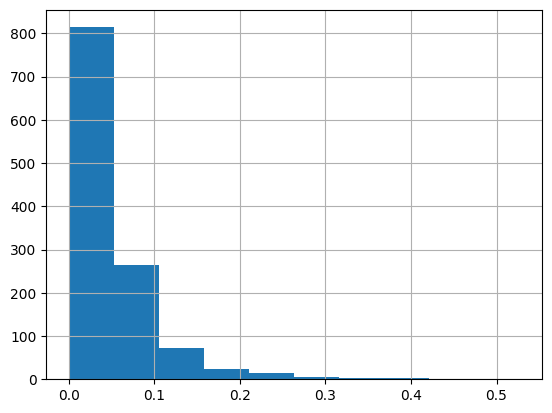

In [307]:
sample_weights =  ret_adj_weigth(t_exits, co_events, close)
sample_weights.hist()

In [310]:
# Export
# Close
close.to_csv("data/close.csv")

# Labels
t_events = inverse_cumsum_filter(close, 0.19, 10)
bins = triple_barrier_method(close, t_events[t_events].index, 30, 20)
bins.to_csv("bins.csv")

# Sample weights
co_events = num_co_events(close.index, bins['hit_date'])
sample_weights = ret_adj_weigth(bins['hit_date'], co_events, close)
sample_weights.to_csv("data/sample_weights.csv")

In [107]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Example data
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([0, 1, 0, 1])

# Example sample weights
sample_weights = np.array([1, 1, 10, 1])  # Giving more weight to the third sample

# Initialize the random forest classifier
rf = RandomForestClassifier(n_jobs=-1)

# Fit the model with sample weights
rf.fit(X, y, sample_weight=sample_weights)

RandomForestClassifier(n_jobs=-1)

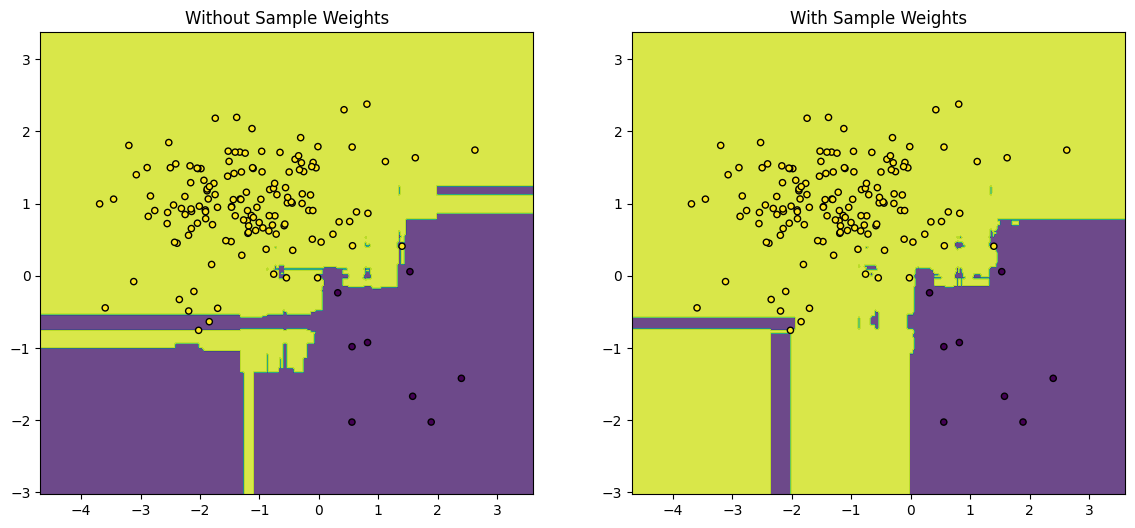

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 1. Generate a synthetic dataset
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.1, 0.9], flip_y=0, random_state=41)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Train Random Forest without sample weights
rf_no_weights = RandomForestClassifier(random_state=41)
rf_no_weights.fit(X_train, y_train)

# 3. Train Random Forest with sample weights (emphasizing the minority class)
sample_weights = np.where(y_train == 0, 10, 1)  # Assign higher weight to the minority class
rf_with_weights = RandomForestClassifier(random_state=42)
rf_with_weights.fit(X_train, y_train, sample_weight=sample_weights)

# 4. Function to plot decision boundaries
def plot_decision_boundary(clf, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=20)
    ax.set_title(title)

# 5. Visualize the decision boundaries with and without sample weights
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot without sample weights
plot_decision_boundary(rf_no_weights, X_test, y_test, ax[0], "Without Sample Weights")

# Plot with sample weights
plot_decision_boundary(rf_with_weights, X_test, y_test, ax[1], "With Sample Weights")

plt.show()